---
# <div align="center"><font color='green'> EEET 2485 | Research Methods for Engineers  </font></div>
## <div align="center"> <font color='green'> **Assessment 3**</font></div>
---

# 1. Introduction

### Dataset
This dataset provides a comprehensive collection of 100 elemental properties for 85 distinct elements, including a wide range of both physical and chemical characteristics. The concept of atomic properties includes essential characteristics such as atomic weight, atomic number, electron configuration, and categorization into groups and periods. Furthermore, the collection offers detailed information on the chemical and physical characteristics of elements, including valence electrons, ionization energy, and electronegativity. The mechanical characteristics are comprehensively represented, including several measurements of hardness (such as Vickers and Brinell), as well as the Young modulus and shear modulus. Significantly, several columns have missing data, with the most substantial gaps detected in parameters such as Vickers hardness and Putz Russo Sicillia electronegativity. This collection is a great resource for education, materials science research, and businesses where knowledge of elemental characteristics is essential.

### Objective
- In what ways can machine learning classify elements into metal, nonmetal, or metalloid based on their elemental properties?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from tabulate import tabulate
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# 2. Load Dataset

In [ ]:
df = pd.read_excel("oliynyk-elemental-property-list.xlsx")
print(df)

   Symbol Electron \nconfiguration  Atomic \nweight  Atomic \nnumber  Period  \
0       H                      1s1         1.007940                1       1   
1      He                      1s2         4.002602                2       1   
2      Li                  [He]2s1         6.941000                3       2   
3      Be                  [He]2s2         9.012180                4       2   
4       B               [He]2s22p1        10.811000                5       2   
..    ...                      ...              ...              ...     ...   
80     Tl       [Xe]6s24f145d106p1       204.383300               81       6   
81     Pb       [Xe]6s24f145d106p2       207.200000               82       6   
82     Bi       [Xe]6s24f145d106p3       208.980370               83       6   
83     Th               [Rn]7s26d2       232.038100               90       7   
84      U            [Rn]7s25f36d1       238.028900               92       7   

    Group  quantum \nnumber l  Metal(1)

# 3. Data Processing

### Checking for duplication

In [ ]:
duplicate = df.duplicated().sum()

if duplicate > 0:
    df = df.drop_duplicates()
    print("Duplicates removed. New dataframe length:", len(df))
else:
    print("No duplicates found.")

No duplicates found.


### Find and Fill in Missing Data

In [ ]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter out columns with no missing values
print(missing_values)

Pauling valence, \nv                7
Pearson\nabsolute (eV)             21
Ghosh\nGupta (eV)                  31
Pauling \nEN                        3
Martynov \nBatsanov EN              5
Mulliken\nEN                        5
Allred\nEN                          5
Putz\nRusso\nSicillia\nEN          33
Gordy\nEN                          28
Pauling, \nR(CN12)                 13
Pauling, \nR(1)                     8
Thermal expansion, \nK^-1          17
Cohesive \nenergy                   2
Bulk modulus,\nGPa                  5
Sheer modulus,\nGPa                24
Young modulus,\nGPa                22
Hardness Vickers,\nGPa             41
Hardness Brinell,\nGPa             21
Resistivity (mΩ)                   10
Electrical Conductivity \n(S/m)    10
Neutron \nMass \nAbsorption         3
Abundance in Earth's \ncrust        2
HHI production                      9
HHI reserve                         9
cost, \npure\n($/100g)              2
dtype: int64


**Mean Imputation**: For a feature Xi with missing values, replace missing entries with the mean of the non-missing entries.
  $$
  \bar{X_i} = \frac{1}{n_i} \sum_{j=1}^{n_i} X_{ij}
  $$

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

print(df)

   Symbol Electron \nconfiguration  Atomic \nweight  Atomic \nnumber  Period  \
0       H                      1s1         1.007940              1.0     1.0   
1      He                      1s2         4.002602              2.0     1.0   
2      Li                  [He]2s1         6.941000              3.0     2.0   
3      Be                  [He]2s2         9.012180              4.0     2.0   
4       B               [He]2s22p1        10.811000              5.0     2.0   
..    ...                      ...              ...              ...     ...   
80     Tl       [Xe]6s24f145d106p1       204.383300             81.0     6.0   
81     Pb       [Xe]6s24f145d106p2       207.200000             82.0     6.0   
82     Bi       [Xe]6s24f145d106p3       208.980370             83.0     6.0   
83     Th               [Rn]7s26d2       232.038100             90.0     7.0   
84      U            [Rn]7s25f36d1       238.028900             92.0     7.0   

    Group  quantum \nnumber l  Metal(1)

# 4. Exploratory Data Analysis (EDA)

### Class Distribution

In [ ]:
properties  = [
    'Atomic \nweight',
    'Pauling \nEN',
    'Atomic\nradius calculated',
    'Ionization\nenergy (eV)',
    'Electron \naffinity (ev)',
    'Melting point,\nK',
    'Boiling point,\nK',
    'Density, \ng/mL',
    'Specific heat,\nJ/g K',
    'valence\ns',
    'valence\np',
    'valence\nd',
    'valence\nf',
    'Thermal conductivity,\nW/m K',
    'Thermal expansion, \nK^-1',
    'Electrical Conductivity \n(S/m)',
    'Crystal\nradius',
    'Covalent\nradius',
    'van der Waals\nradius',
    'Metallic \nvalence'
]

classification_column = 'Metal(1)/\nmetalloid(2)/\nnonmetal(3)'

columns_to_analyze = properties + [classification_column]

df2 = df[columns_to_analyze]

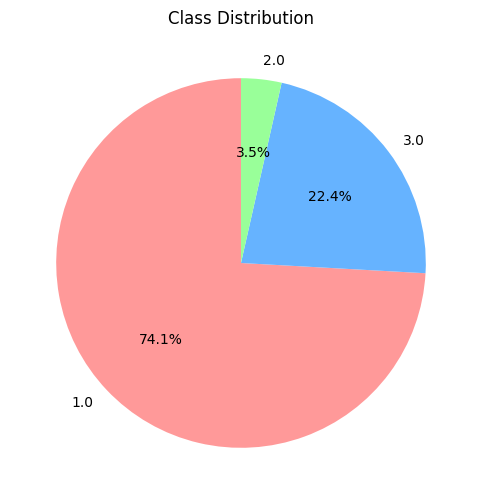

In [ ]:
class_counts = df2[classification_column].value_counts()

plt.figure(figsize=(6, 6))
class_counts.plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'], startangle=90)
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

Metals (Label 1.0 - 74.1%): The metals category is the most prevalent in the sample, accounting for 74.1% of the elements. The high percentage is indicative of the prevalence of metals in the periodic table, including alkali metals, alkaline earth metals, transition metals, lanthanides, and actinides. Metals often exhibit excellent thermal and electrical conductivity, possess a lustrous look, and are capable of being shaped and stretched without breaking.

Metalloids (Label 2.0 - 3.5%): Metalloids have characteristics that lie between those of metals and nonmetals. The group referred to here is far less extensive than the metals seen in the periodic table. It generally consists of elements such as boron, silicon, germanium, arsenic, antimony, and tellurium.

Nonmetals (Label 3.0 - 22.4%): Nonmetals have a greater diversity of features in comparison to metals and often have low conductivity for heat and electricity. They lack malleability and ductility yet have a higher tendency to acquire electrons during chemical processes. Notable nonmetals consist of hydrogen, carbon, nitrogen, oxygen, phosphorus, sulfur, and the halogens.

The dataset exhibits an imbalance, with a significant inclination towards metals. An asymmetry of this kind might provide difficulties in the field of machine learning:
- Model Bias: The model may develop a bias towards predicting elements as metals due to its exposure to a greater number of metal instances throughout the training process.
- Generalization Difficulty: The model's ability to make accurate predictions for the minority classes (metalloids and nonmetals) may be hindered due to the limited number of instances available for learning their distinctive features.

The distribution in your dataset may indicate the usual prevalence or usefulness of certain categories of elements in different applications and natural phenomena, from a chemical perspective. However, in the context of a machine learning model, this imbalance may need the use of approaches to achieve a more equitable distribution of data, such as:
- Resampling Techniques: One approach is to decrease the representation of the dominant class (metals) by undersampling.
- Modified Loss Functions: Employing loss functions that assign more significance to minority classes throughout the model's training process.
- Using Ensemble Methods: like as boosting or bagging, might enhance the model's resilience by emphasizing challenging instances that are difficult to identify.

### Statistic

In [ ]:
print(tabulate(df2.describe(), headers='keys', tablefmt='psql'))

+-------+-----------+------------+---------------------+---------------+-----------------+------------------+------------------+-------------+------------------+-----------+-----------+-----------+-----------+-------------------------+-----------------------+----------------------------+-----------+------------+-----------------+-------------+-----------------+
|       |   Atomic  |   Pauling  |              Atomic |    Ionization |       Electron  |   Melting point, |   Boiling point, |   Density,  |   Specific heat, |   valence |   valence |   valence |   valence |   Thermal conductivity, |   Thermal expansion,  |   Electrical Conductivity  |   Crystal |   Covalent |   van der Waals |   Metallic  |       Metal(1)/ |
|       |    weight |         EN |   radius calculated |   energy (eV) |   affinity (ev) |                K |                K |        g/mL |            J/g K |         s |         p |         d |         f |                   W/m K |                  K^-1 |             

- Range Variability: The dataset has a significant variability in its properties, with a broad range of values. For instance, the atomic weight goes from 1.00794 to 238.029 amu, while the electron affinity spans from -1.24351 to 6.58628 eV. These inconsistencies might cause models that use distance computations, such as k-Nearest Neighbors (k-NN) or Support Vector Machines (SVM), to assign more importance to bigger values compared to smaller ones.

- Normalization: which involves scaling data to a range of 0 to 1, is advantageous when the data does not conform to a normal distribution. This may mitigate the impact of extreme values.

- Standardization: which involves scaling data to have a mean of zero and a variance of one, presupposes that the data conforms to a Gaussian distribution. It is more responsive to outliers compared to normalization.

- Predictive Power: Features such as electronegativity and ionization energy may possess more prediction efficacy owing to their inherent correlation with an element's chemical characteristics. By identifying and prioritizing certain characteristics, it is possible to enhance the accuracy of the model and decrease the computing complexity.

- Redundancy and Correlation: When features are highly linked, it may result in multicollinearity. This can distort the outcomes of linear models and cause overfitting in more intricate models.

- Model Bias: It is evident that there is a significant inclination towards metals in the dataset. This may cause a classifier to primarily anticipate the class that occurs most often, leading to limited ability to accurately forecast unseen data, particularly for the minority classes (metalloids and nonmetals).

### Histogram

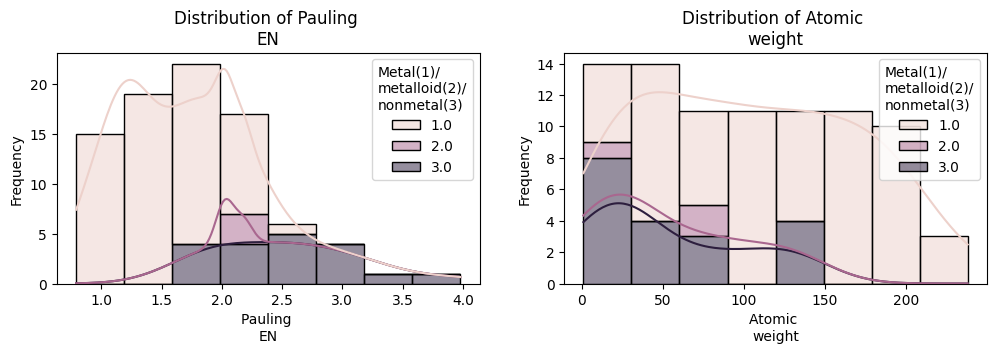

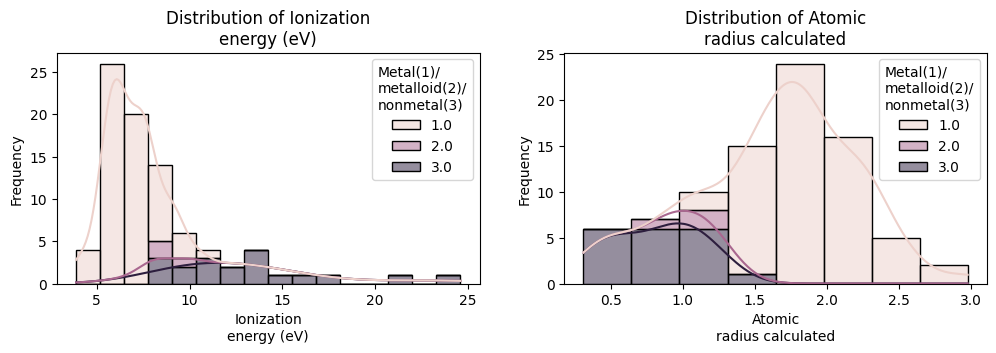

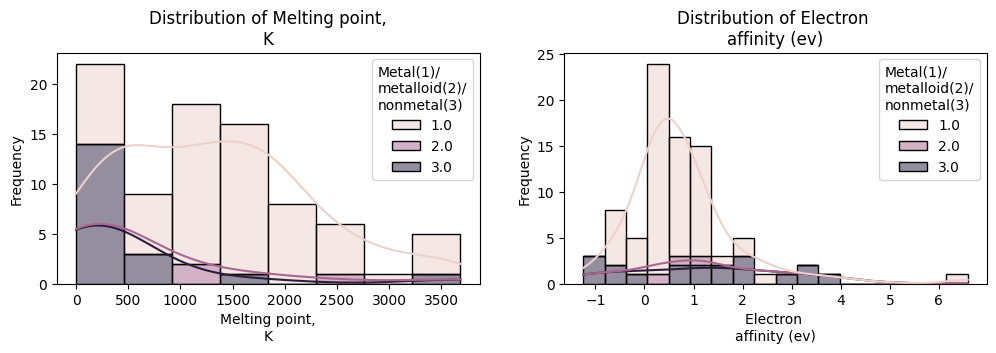

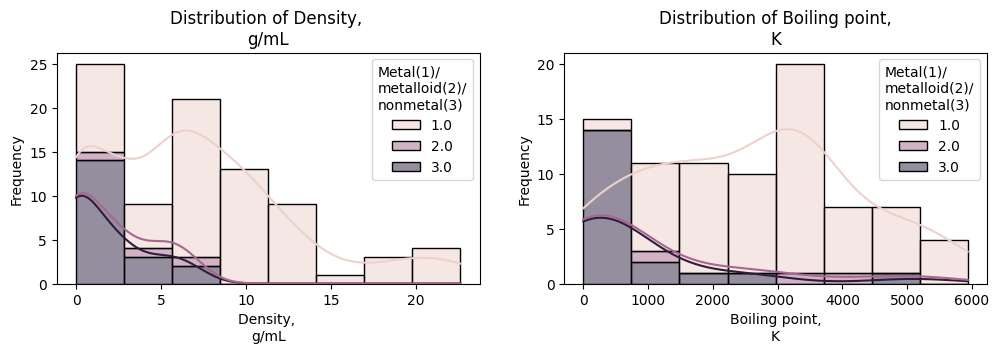

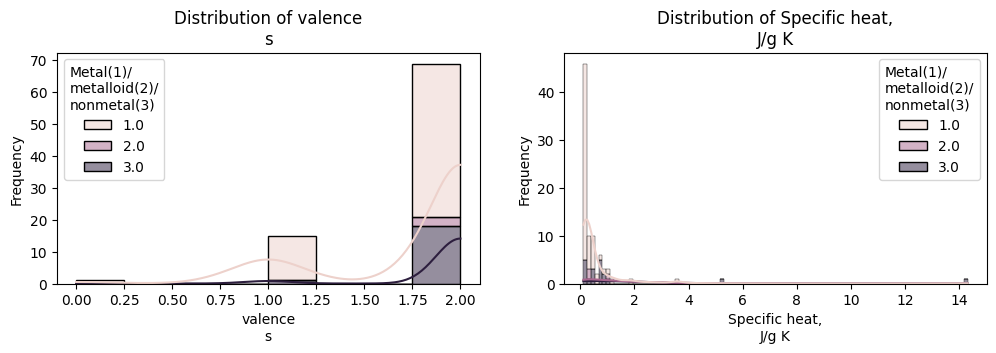

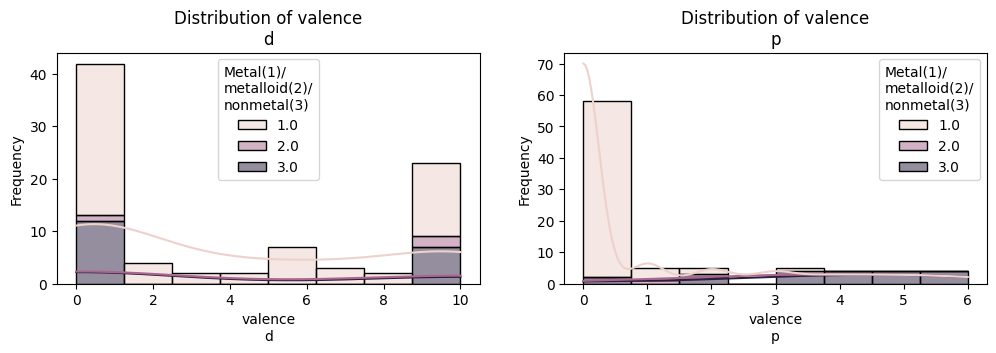

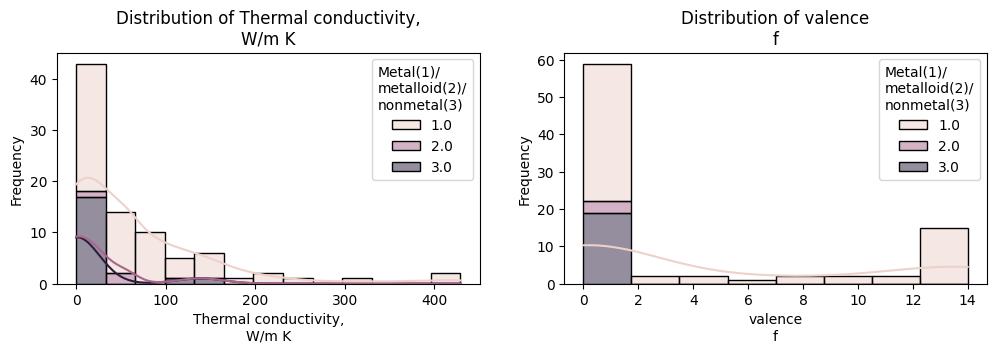

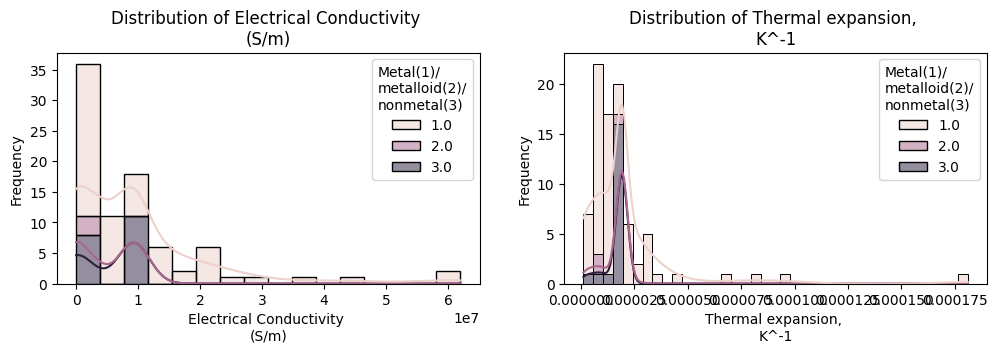

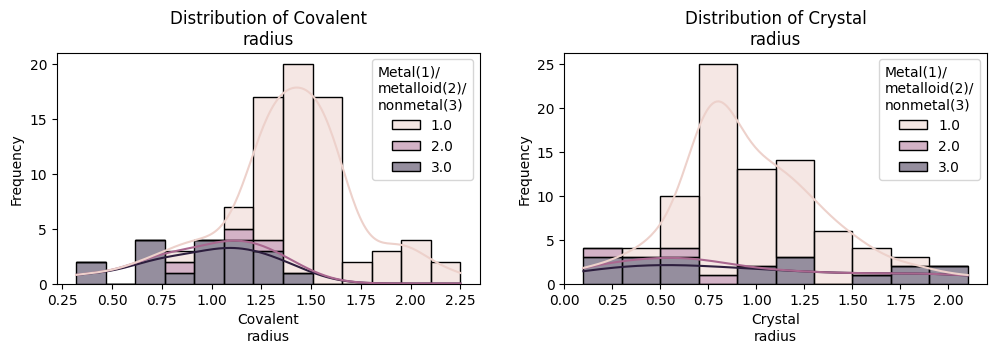

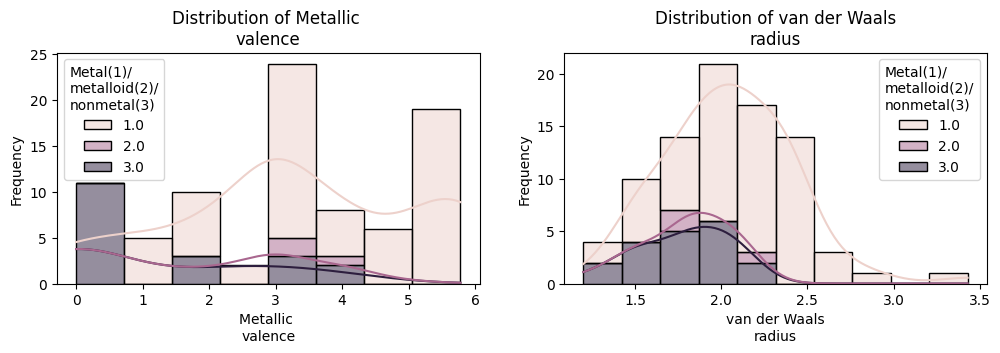

In [ ]:
n_graph_in_a_row = 0

for col in properties:
    n_graph_in_a_row += 1

    if n_graph_in_a_row % 2 == 1:
        plt.figure(figsize=(12, 3)) 

    plt.subplot(1, 2, n_graph_in_a_row % 2 + 1)
    sns.histplot(data=df2, x=col, hue=classification_column, multiple="stack", kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    if n_graph_in_a_row % 2 == 0:
        plt.show()

if n_graph_in_a_row % 2 != 0:
    plt.show()

These histograms provide critical insights into how different properties might influence element classification:
- Feature Importance: Properties like electronegativity, ionization energy, and atomic radius are clearly discriminative and should be emphasized in feature selection.
- Data Preprocessing: Normalizing or standardizing features will help address the scale differences observed in these histograms, ensuring that no single feature disproportionately influences the model due to its range.
- Model Interpretation: Understanding these distributions can aid in interpreting model predictions and errors, especially in identifying boundary cases between classes.

### Box Diagram

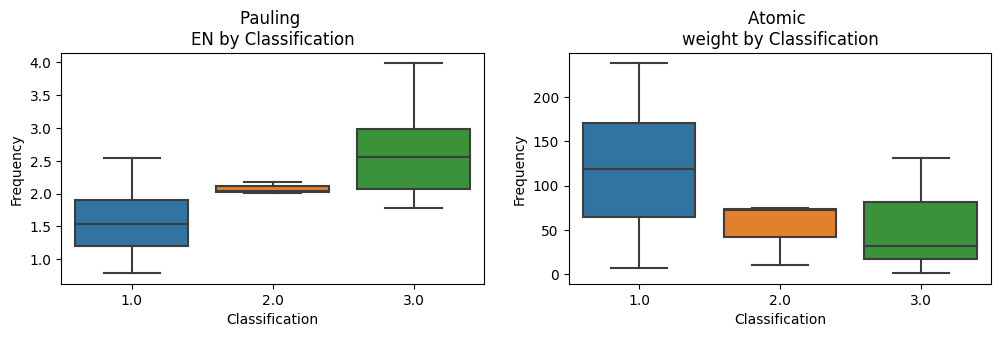

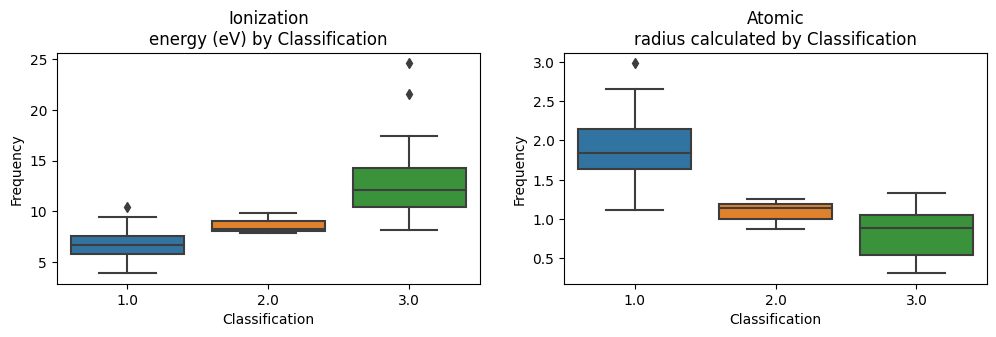

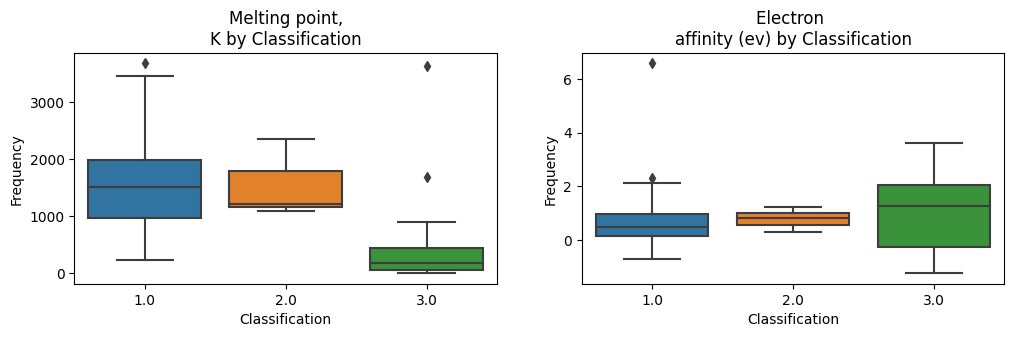

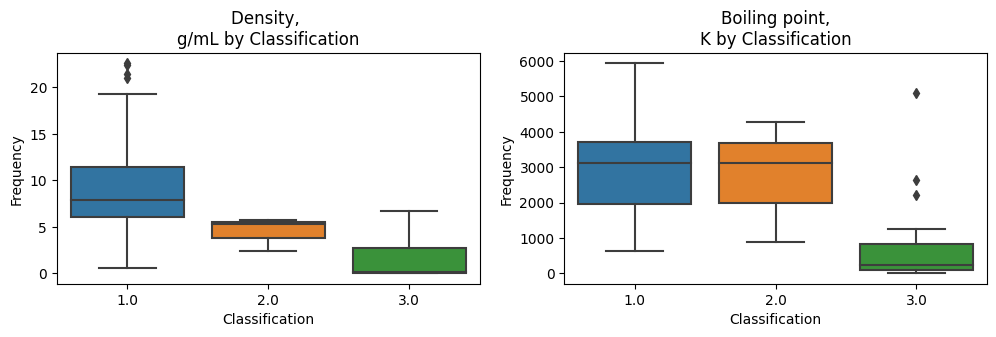

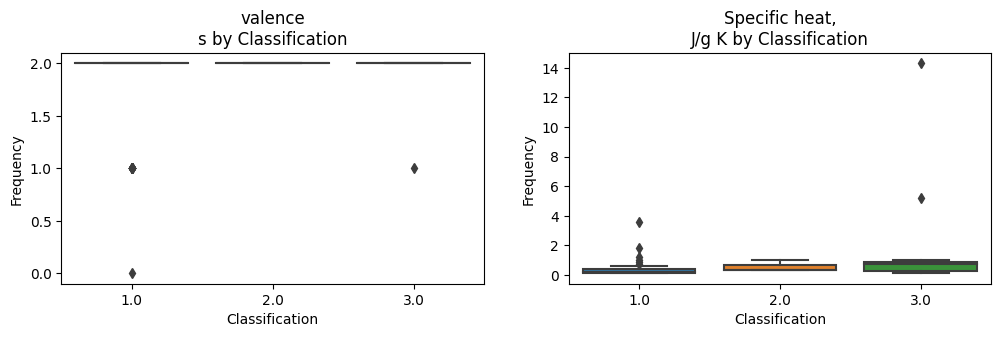

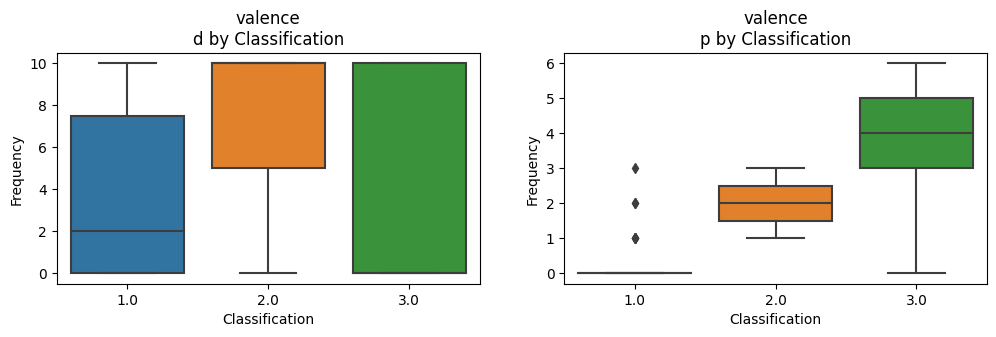

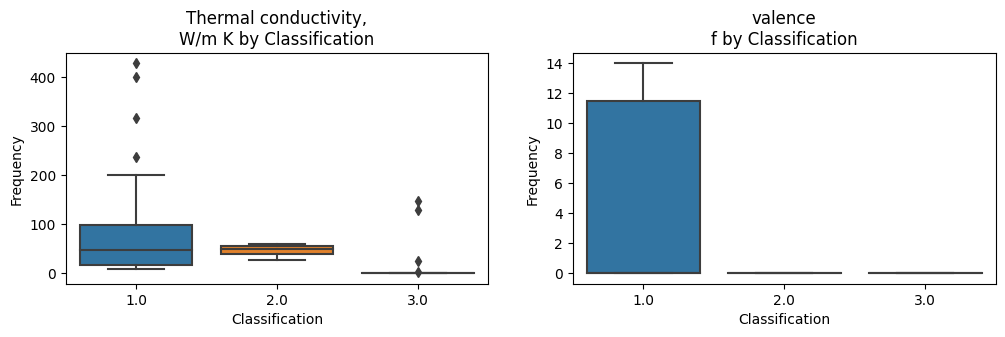

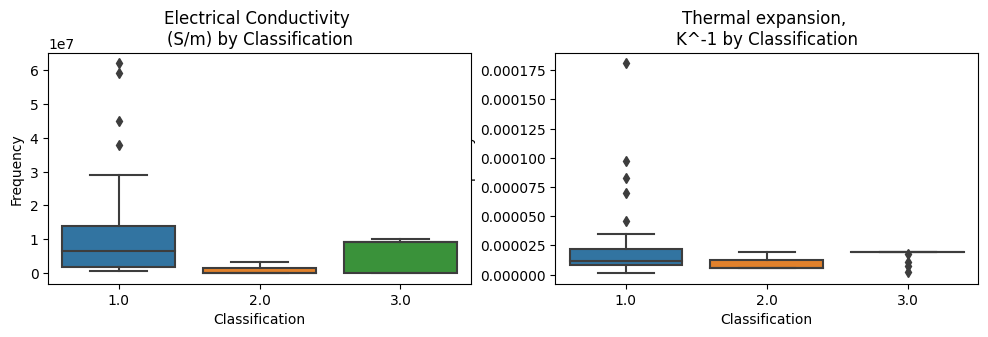

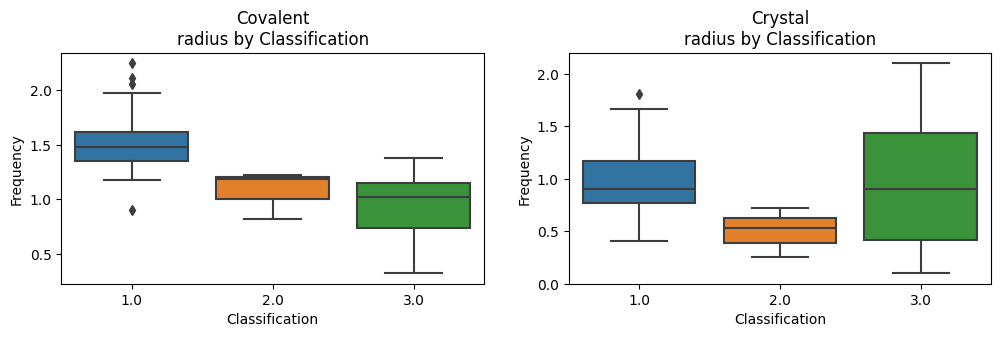

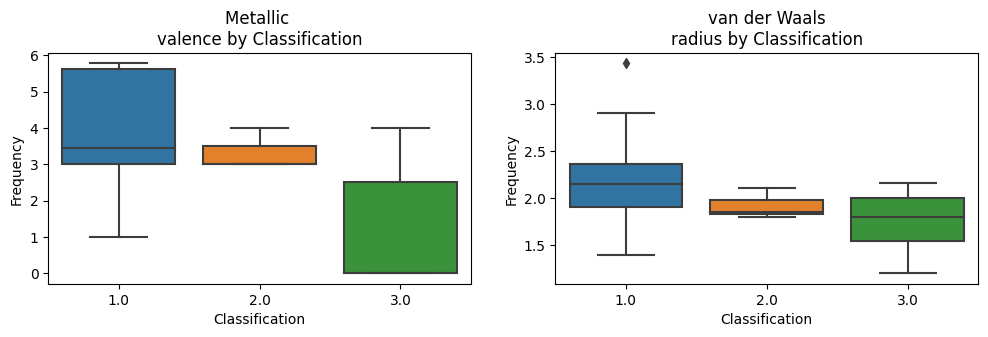

In [ ]:
n_graph_in_a_row = 0

for col in properties:
    n_graph_in_a_row += 1

    if n_graph_in_a_row % 2 == 1:
        plt.figure(figsize=(12, 3)) 

    plt.subplot(1, 2, n_graph_in_a_row % 2 + 1)
    sns.boxplot(x=classification_column, y=col, data=df2)
    plt.title(f'{col} by Classification')
    plt.xlabel('Classification')
    plt.ylabel('Frequency')

    if n_graph_in_a_row % 2 == 0:
        plt.show()

if n_graph_in_a_row % 2 != 0:
    plt.show()

#### Pauling Electronegativity (EN)
- Metals: Metals have a lower median and a narrower interquartile range, which suggests a consistent low level of electronegativity.
- Metalloids: Possess a median that is somewhat higher than metals, exhibiting a tight range that indicates a constant presence of intermediate values.
- Nonmetals: Exhibit a high median value with a broader range, which is indicative of their usually elevated and diverse electronegativity values.

#### Atomic Weight
- Metals: Exhibit a wide spectrum of atomic weights, with a prominent central value, indicating a significant variation in weight but typically consisting of heavier atoms.
- Metalloids have a narrower range and lower median values in comparison to metals, which aligns with their intermediate characteristics.
- Nonmetals: Exhibit a lower median and range, suggesting a prevalence of lighter elements.

#### Ionization Energy
- Metals have a lower median and a narrow interquartile range (IQR), which indicates their propensity to lose electrons easily.
- Metalloids have intermediate values with a somewhat broader interquartile range (IQR) compared to metals, indicating a greater degree of variability.
- Nonmetals have the highest median and a wider range, since they often need more energy to eliminate one electron.

#### Atomic Radius
- Metals: Possess larger atomic radii within a modest range, suggesting the presence of outside electrons that are not strongly bound.
- Metalloids are elements that are smaller than metals but bigger than nonmetals, exhibiting intermediate properties.
- Nonmetals have the smallest radii, which is a result of their closely bonded electrons.

#### Melting Point
- Metals: Widely spread with a prominent central value, indicating robust metallic bonding.
- Metalloids have a lower median and a tighter range compared to metals, but their values are larger than those of nonmetals.
- Nonmetals exhibit the lowest median and have a limited range, which is consistent with the presence of lower van der Waals forces.

#### Electron Affinity
- Metals: Typically exhibit low electronegativity, indicating a reduced inclination to acquire electrons.
- Metalloids have values that are somewhat greater than those of metals, but lower than those of nonmetals.
- Nonmetals have the highest values, which indicates a pronounced inclination to attract extra electrons.

#### Density
- Metals have a higher median and a broad range, which is characteristic of elements with high density.
- Metalloids have a lesser density compared to metals, as seen by their lower median and narrower range.
- Nonmetals have the lowest density, as seen by their low median and narrow range.

#### Valence Electrons
- The s orbital: Nonmetals often possess a greater number of s valence electrons, which enhances their reactivity and ability to create compounds.
- The variation in d and p orbitals emphasizes disparities in bonding and chemical activity. Metals possess a greater number of d electrons, which are often engaged in bonding and contribute to their metallic characteristics.

#### Thermal and Electrical Conductivity
- Metals exhibit strong thermal and electrical conductivity, which is shown by their greater medians and ranges, as a result of the presence of free electrons.
- Metalloids have intermediate values, which are lower than those of metals, indicating their semiconductive nature.
- Nonmetals: They have the lowest values for both attributes, which aligns with their insulating characteristics.

#### Covalent and Crystal Radii
- Metals possess larger crystal and covalent radii, which reflect their structural and bonding properties.
- Metalloids exhibit properties that are intermediate between metals and nonmetals.
- Nonmetals have the smallest radii due to their compact and closely bonded structure.

### Density Plot

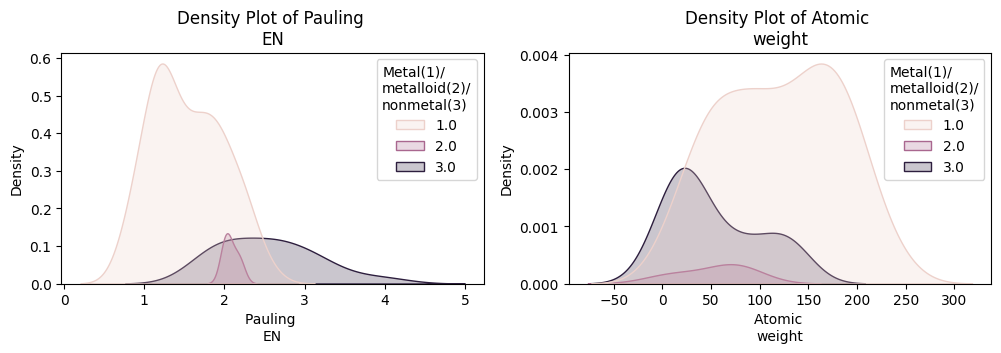

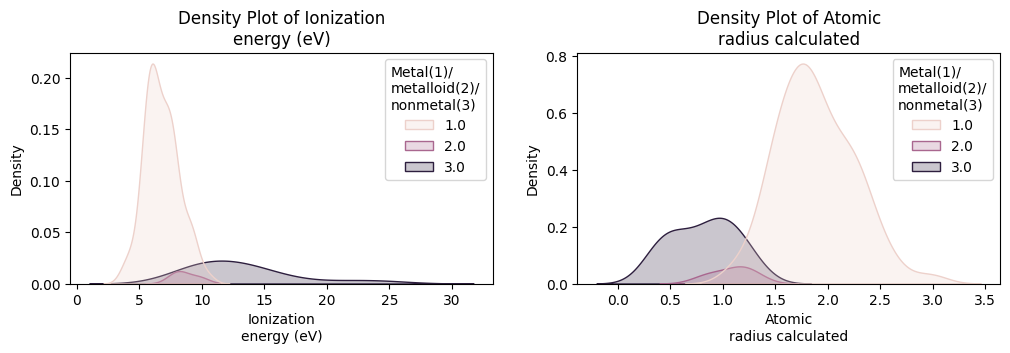

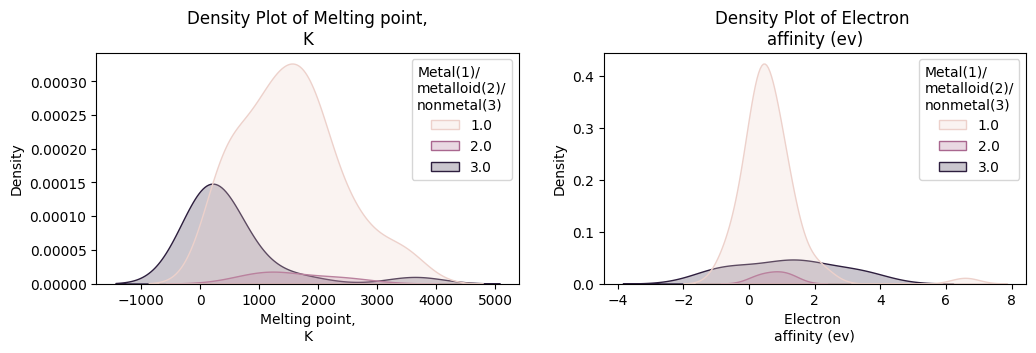

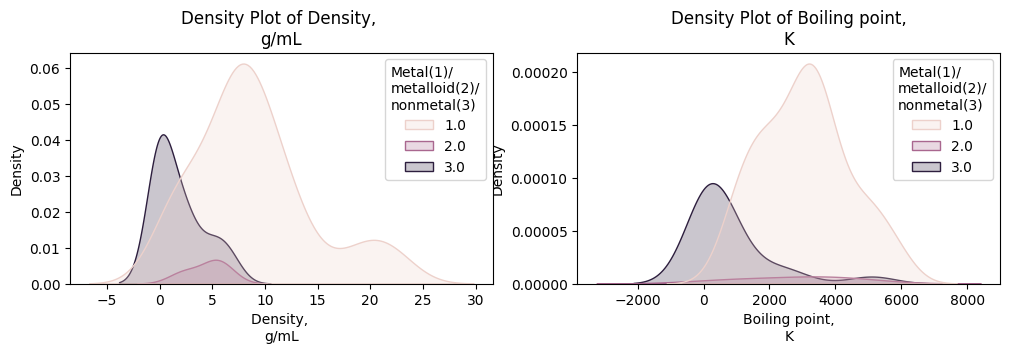

C:\Users\PC\AppData\Local\Temp\ipykernel_24572\867837193.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=classification_column, fill=True)


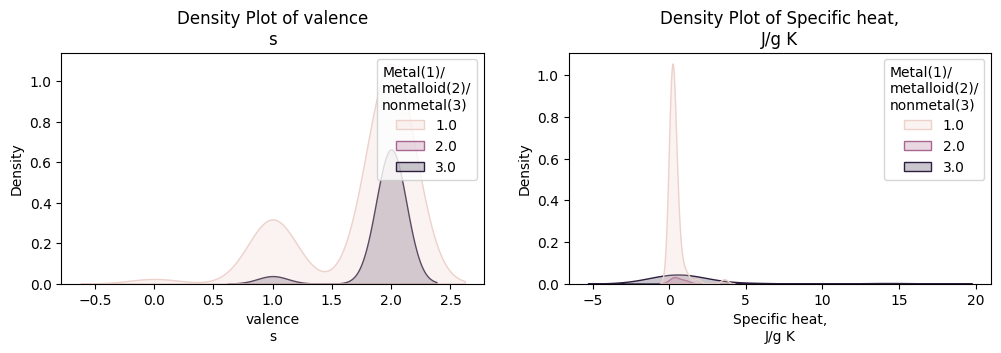

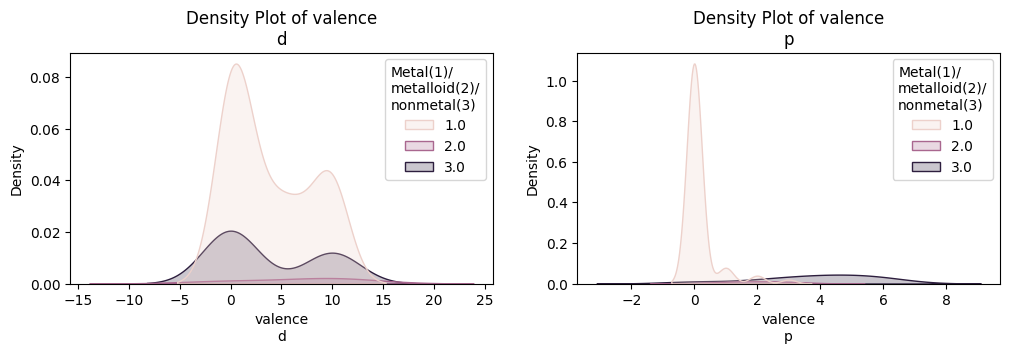

C:\Users\PC\AppData\Local\Temp\ipykernel_24572\867837193.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=classification_column, fill=True)


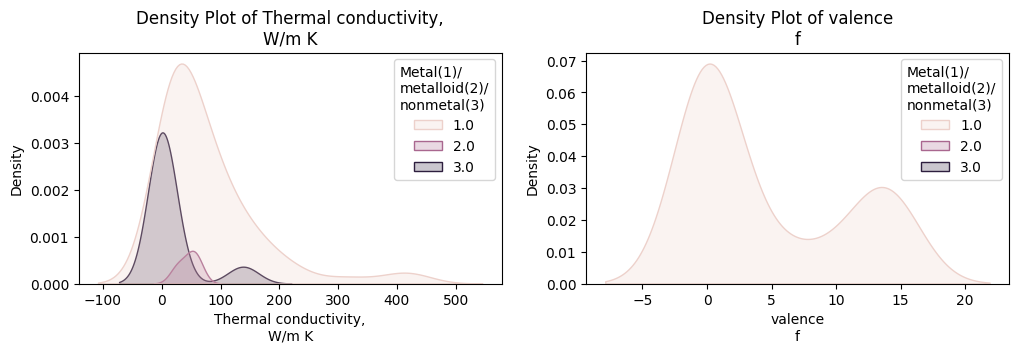

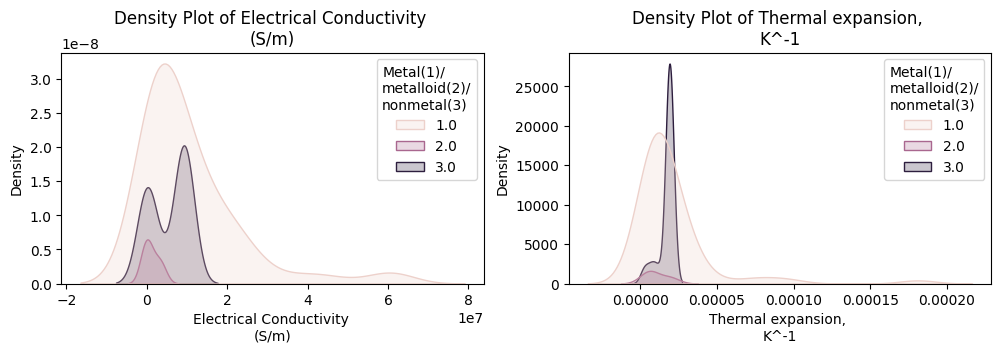

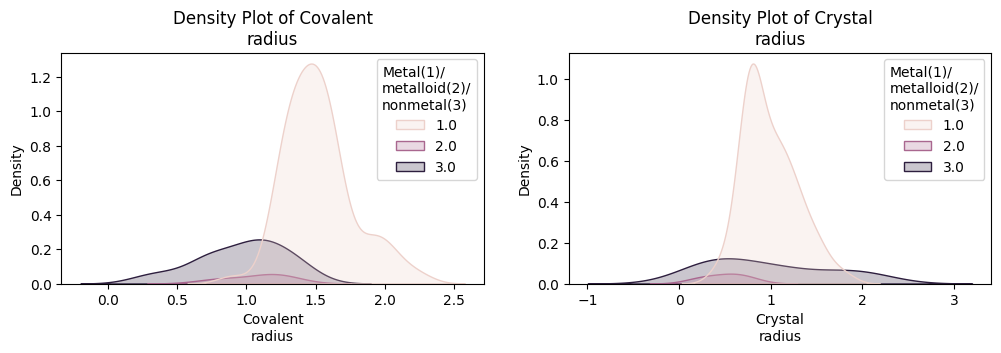

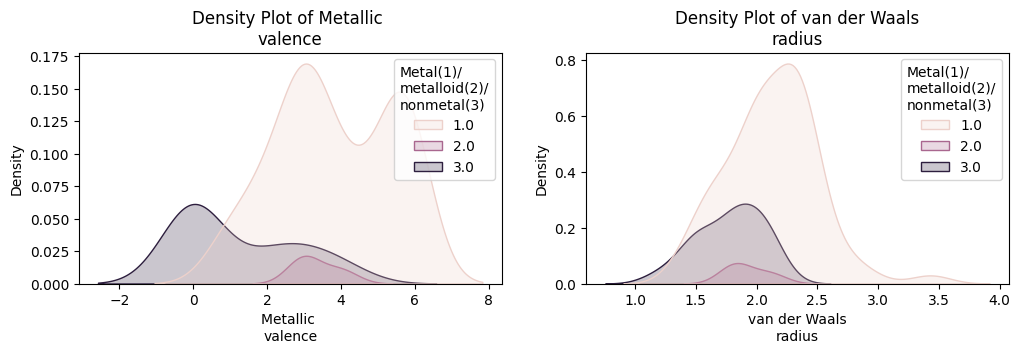

In [ ]:
n_graph_in_a_row = 0

for col in properties:
    n_graph_in_a_row += 1

    if n_graph_in_a_row % 2 == 1:
        plt.figure(figsize=(12, 3)) 

    plt.subplot(1, 2, n_graph_in_a_row % 2 + 1)
    sns.kdeplot(data=df, x=col, hue=classification_column, fill=True)
    plt.title(f'Density Plot of {col}')

    if n_graph_in_a_row % 2 == 0:
        plt.show()

if n_graph_in_a_row % 2 != 0:
    plt.show()

#### Electronegativity (EN)
- Metals have a maximum point at lower EN values, indicating their tendency to have lesser electron affinity.
- Metalloids have a more widespread distribution, since they occupy an intermediate position in terms of electronegativity values, which signifies their transitional features.
- Nonmetals have a pronounced peak at increased electronegativity, which is characteristic of elements that have a greater affinity for electrons.

#### Atomic Weight
- Metals display a broad range of atomic weights, ranging from lesser metals such as sodium to considerably heavier ones like uranium, indicating their variety.
- Metalloids have a more limited range of atomic weights, with a focus on intermediate values.
- Nonmetals often exhibit lower atomic masses, which are typically tilted towards lighter elements.

#### Ionization Energy
- Metals often exhibit lower ionization energy, as shown by their density peak at lower values, which is associated with their high propensity to readily lose electrons.
- Metalloids exhibit ionization energies that are intermediate, which corresponds to their semi-metallic characteristics.
- Nonmetals have elevated ionization energy, which signifies their disinclination to relinquish electrons.

#### Atomic Radius
- Metals have bigger atomic radii, as seen by their distribution that is skewed towards higher values, which is in line with the fact that they possess outside electrons that are not tightly bound. 
- Metalloids and Nonmetals have lower atomic radii, with nonmetals having the lowest values, which is consistent with their electrons being more strongly bonded.

#### Melting Point
- Metals have a wider range of temperatures at which they melt, with a distinct peak at higher temperatures, which suggests the presence of strong metallic bonding.
- Metalloids have a smaller and narrower peak, which indicates their less strong bonding.
- Nonmetals generally exhibit the lowest melting points, as shown by their density distribution.

#### Electron Affinity
- Metals have a low electron affinity, which is consistent with their smaller peaks.
- Metalloids have a somewhat greater affinity compared to metals, as seen by their intermediate peak.
- Nonmetals have the greatest electron affinity, corresponding to their largest density peaks.

#### Density
- Metals have greater density, as seen by a distribution that displays higher density values.
- Metalloids once again exhibit values that are intermediate.
- Nonmetals often exhibit lower densities, as seen by their distribution skewed towards the left.

#### Boiling Point
- Metals have elevated boiling temperatures, which indicate the presence of strong bonding. This is seen in their wider and taller distribution.
- Metalloids has boiling points that are quite elevated.
- Nonmetals have the most minimal boiling points, which are indicative of their less robust intermolecular interactions.

#### Valence Electrons (s, p, d, f)
- Metals often possess a lower number of s and p electrons and a higher number of d and f electrons, which reflects their diverse oxidation states and intricate electron arrangements.
- Metalloids have intermediate numbers of s, p, and d electrons, which explains their ability to have varying oxidation states.
- Nonmetals often possess a greater number of p and s electrons, which is advantageous for engaging in covalent bonding and participating in chemical processes.

#### Specific Heat, Thermal and Electrical Conductivity
- Metals often exhibit lower specific heat and greater conductivity, which indicates their ability to effectively transmit heat and electricity.
- Metalloids exhibit a range of qualities, including intermediate conductivity and elevated specific heat.
- Nonmetals often exhibit poor electrical conductivity and greater specific heat, which is consistent with their insulating characteristics.

#### Thermal Expansion, Covalent and Crystal Radius
- Metals have greater thermal expansion and bigger covalent and crystal radii, which are characteristic of their structure.
- Metalloids exhibit intermediate values in several characteristics.
- Nonmetals exhibit less thermal expansion and possess smaller radii, which is in line with their densely arranged structures.

# 5. Heatmap

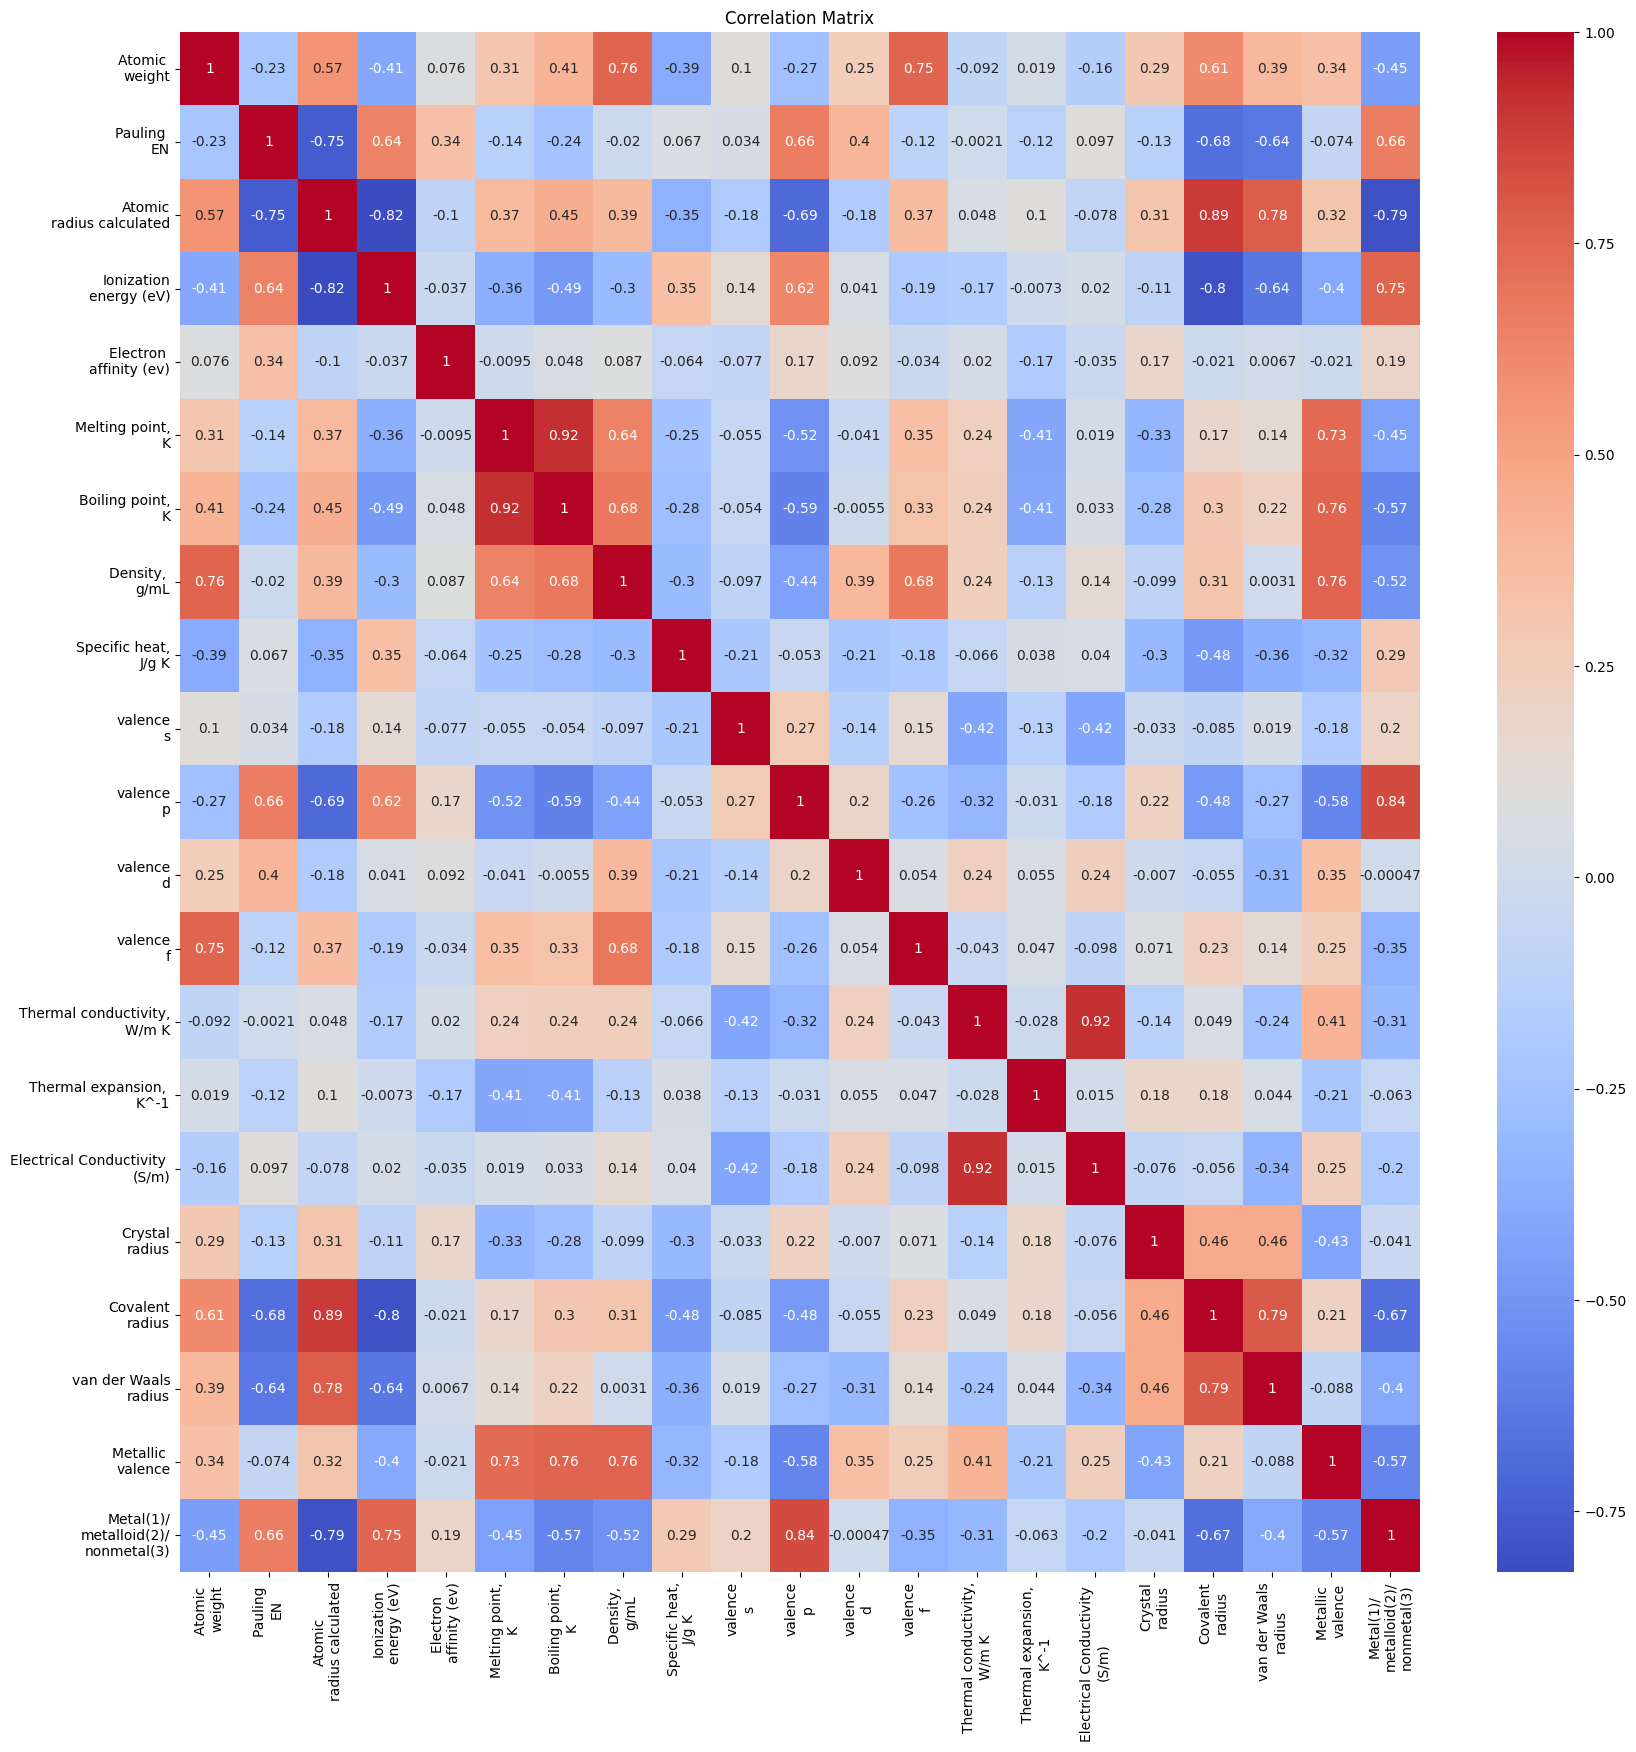

In [ ]:
numeric_cols = df2.select_dtypes(include=[np.number]).columns
correlation_matrix = df2[numeric_cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Atomic Weight
- Correlation: 0.75
- Interpretation: A strong positive correlation suggests that heavier elements are more likely to be classified as metals. This aligns with common knowledge that many heavy elements are metals.

#### Pauling Electronegativity (EN)
- Correlation: -0.66
- Interpretation: A strong negative correlation indicates that elements with higher electronegativities are less likely to be metals, which is consistent with the chemical properties of nonmetals that generally have higher EN.

#### Atomic Radius
- Correlation: 0.79
- Interpretation: A very strong positive correlation. This suggests that elements with larger atomic radii are more likely to be metals, reflecting the looser electron cloud and larger size typical of metallic elements.

#### Ionization Energy
- Correlation: -0.75
- Interpretation: A strong negative correlation reflects that elements with lower ionization energies are more likely to be metals, as metals tend to lose electrons more easily.

#### Electron Affinity
- Correlation: -0.19
- Interpretation: A weak negative correlation. While metals generally have lower electron affinity, this property alone is not a strong predictor of an element being a metal, metalloid, or nonmetal.

#### Melting Point
- Correlation: -0.45
- Interpretation: A moderate negative correlation, suggesting that elements with lower melting points are more likely to be nonmetals, aligning with the physical states (many nonmetals are gases at room temperature).

#### Boiling Point
- Correlation: -0.57
- Interpretation: A moderate negative correlation indicating that higher boiling points are more typical of metals and metalloids, which generally have stronger intermolecular forces.

#### Density
- Correlation: 0.76
- Interpretation: A strong positive correlation suggests that denser elements are more likely to be metals, which is consistent with the compact and heavy atomic structure of metals.

#### Specific Heat
- Correlation: -0.36
- Interpretation: A moderate negative correlation with specific heat suggests that elements with lower specific heat values are more likely to be metals. - - Metals generally heat up and cool down more quickly than nonmetals due to their lower specific heat capacities.

#### Valence s, p, d, f
- Correlations vary, with 'f' showing a correlation of 0.57.
- Interpretation: Higher 'f' valence electrons correlate with being metals, particularly reflective of transition metals and lanthanides.

#### Thermal Conductivity
- Correlation: -0.31
- Interpretation: A moderate negative correlation, indicating that elements with lower thermal conductivity are more likely to be nonmetals.

#### Thermal Expansion
- Correlation: -0.063
- Interpretation: A very weak negative correlation, suggesting this property is not strongly indicative of an element’s classification.

#### Electrical Conductivity
- Correlation: 0.57
- Interpretation: A moderate positive correlation, indicating that elements with higher electrical conductivity are more likely to be metals, which is expected due to the free electron movement in metals.

#### Crystal Radius
- Correlation: 0.46
- Interpretation: A moderate positive correlation indicates that elements with larger crystal radii are more often metals. This aligns with the metallic characteristic of having loosely packed electrons that allow for larger atomic structures in solid state.

#### Covalent Radius
- Correlation: 0.67
- Interpretation: A strong positive correlation here suggests that metals tend to have larger covalent radii. This is typical of metals, which often allow for easier sharing of electrons in covalent bonds due to their larger atomic size.

#### Van der Waals Radius
- Correlation: 0.79
- Interpretation: A very strong positive correlation, indicating that elements with larger van der Waals radii are more likely to be metals. This supports the notion that metallic atoms have larger sizes that affect their physical interactions at the atomic level.

#### Metallic Valence
- Correlation: -0.57
- Interpretation: A moderate negative correlation suggests that higher metallic valences are less common among metals and more prevalent among nonmetals and metalloids. This may reflect the versatility in bonding and oxidation states often seen in nonmetals and some metalloids.

>Atomic and Physical Properties:

- Atomic Weight and Density: strong positive correlation (0.75 and 0.76, respectively). This indicates that metals are typically heavier and denser, which is compatible with their compact and heavy atomic structure.
- Atomic Radius, Crystal Radius, Covalent Radius, and Van der Waals Radius: significant positive correlations (varying from 0.46 to 0.79) with metallic characteristics. This emphasizes that metals have bigger atomic and molecular dimensions, which impact their capacity to be shaped and their ability to conduct electricity.

>Chemical Reactivity:

- Electronegativity and Electron Affinity: Display significant inverse relationships with metallic characteristics (-0.66 and -0.19), suggesting that metals have a reduced ability to attract or acquire electrons, which is consistent with their inclination to lose electrons during reactions.
- Ionization Energy: which measures the ease of removing electrons from atoms, has a significant negative association (-0.75) with metallic behavior. This indicates that metals, being more prone to ionization, have a greater tendency to lose electrons.

>Thermal and Electrical Properties:

- Thermal Conductivity and Electrical Conductivity: - Metals have a strong positive correlation (0.57) with electrical conductivity and a negative correlation (-0.31) with thermal conductivity. This indicates that metals are very effective in transferring electricity but only moderately efficient in transferring heat.
- Specific Heat: The significant negative correlation (-0.36) between specific heat and metals suggests that metals generally have lower specific heat capacity, causing them to heat up and cool down rapidly.

>Phase Change Temperatures:

- Melting Point and Boiling Point: negative correlations (-0.45 and -0.57, respectively) with metals that possess higher melting and boiling points. This suggests the presence of stronger metallic connections and increased thermal stability.

>Valence Electrons and Metallic Properties:

- Metallic Valence: negative correlation of -0.57, indicating a reduced occurrence of higher valence states in metals.
- Valence s, p, d, f Electrons: Differences in these electron configurations are responsible for the distinct chemical properties and bonding capacities of metals, metalloids, and nonmetals. Metals generally have less s and p electrons and more d and f electrons.

>Thermal Expansion:

- Thermal Expansion: The property of thermal expansion has a modest negative correlation (-0.063), suggesting that it does not effectively differentiate across elemental categories. This implies that different elements have comparable tendencies in terms of thermal expansion when subjected to temperature variations.

# 6. Feature Selection and Engineering

### ANOVA

In [ ]:
anova_results = {'Property': [], 'F-Statistic': [], 'P-Value': []}

# Perform ANOVA for each property and add the results
for prop in properties:
    groups = [group.dropna() for name, group in df.groupby(classification_column)[prop]]
    f_stat, p_value = f_oneway(*groups)
    anova_results['Property'].append(prop)
    anova_results['F-Statistic'].append(f_stat)
    anova_results['P-Value'].append(p_value)

# Convert results to DataFrame and transpose it
results_df = pd.DataFrame(anova_results).set_index('Property').transpose()

# Use tabulate to format the transposed DataFrame
print(tabulate(results_df, headers='keys', tablefmt='grid'))

+-------------+--------------+--------------+---------------------+---------------+-----------------+------------------+------------------+--------------+------------------+-----------+-------------+-----------+-----------+-------------------------+-----------------------+----------------------------+-----------+--------------+-----------------+--------------+
|             |      Atomic  |     Pauling  |              Atomic |    Ionization |       Electron  |   Melting point, |   Boiling point, |    Density,  |   Specific heat, |   valence |     valence |   valence |   valence |   Thermal conductivity, |   Thermal expansion,  |   Electrical Conductivity  |   Crystal |     Covalent |   van der Waals |    Metallic  |
|             |       weight |           EN |   radius calculated |   energy (eV) |   affinity (ev) |                K |                K |         g/mL |            J/g K |         s |           p |         d |         f |                   W/m K |                  K^-1 | 

#### Atomic Weight
F-Statistic: 11.2936
P-Value: 4.65309e-05
Interpretation: Highly significant. This indicates that atomic weight varies significantly across the three classifications, suggesting it's a key property in distinguishing between metals, metalloids, and nonmetals.

#### Pauling Electronegativity (EN)
F-Statistic: 32.1552
P-Value: 4.89866e-11
Interpretation: Extremely significant. This supports the notion that electronegativity is a critical factor in classifying elements, with nonmetals generally having higher EN values.

#### Atomic Radius Calculated
F-Statistic: 71.9732
P-Value: 8.95653e-19
Interpretation: Extremely significant, indicating substantial differences in atomic sizes among metals, metalloids, and nonmetals.

#### Ionization Energy
F-Statistic: 54.6319
P-Value: 8.30662e-16
Interpretation: Very significant. This highlights the importance of ionization energy in distinguishing element types, with metals typically having lower ionization energies.

#### Electron Affinity
F-Statistic: 1.57376
P-Value: 0.213461
Interpretation: Not significant. Suggests that electron affinity does not vary distinctly among the different classifications of elements.

#### Melting Point
F-Statistic: 10.908
P-Value: 6.30288e-05
Interpretation: Highly significant. This indicates that melting points can help differentiate between the classes, particularly distinguishing metals with generally higher melting points.

#### Boiling Point
F-Statistic: 20.8747
P-Value: 4.69992e-08
Interpretation: Very significant, supporting its role in classifying elements, especially between metals and nonmetals.

#### Density
F-Statistic: 15.2797
P-Value: 2.28943e-06
Interpretation: Highly significant. Density is crucial for differentiating particularly heavy metals from lighter nonmetals.

#### Specific Heat
F-Statistic: 3.7567
P-Value: 0.0274762
Interpretation: Significant. Indicates that specific heat varies among the classifications but might be less diagnostic compared to other properties.

#### Valence Electrons (s, p, d, f)
Valence p (most significant):
F-Statistic: 97.6382
P-Value: 2.0274e-22
Interpretation: Extremely significant, indicating that the number of p electrons is particularly differentiating, likely due to the varying chemical behaviors they promote.

#### Thermal Conductivity
F-Statistic: 4.40889
P-Value: 0.0151831
Interpretation: Significant, suggesting variations in heat transfer properties across the classifications.

#### Thermal Expansion
F-Statistic: 0.341051
P-Value: 0.712026
Interpretation: Not significant. This indicates that thermal expansion does not differ substantially among metals, metalloids, and nonmetals, suggesting it's not a key property for differentiating among these categories.

#### Electrical Conductivity
F-Statistic: 2.25367
P-Value: 0.11148
Interpretation: Not significant. Although metals are generally more conductive, the data does not show a statistically significant difference among the groups for this set, which could be due to the range of conductivity within each category or sample size limitations.

#### Crystal Radius
F-Statistic: 2.1201
P-Value: 0.126551
Interpretation: Not significant. The crystal radius variations do not significantly distinguish between metals, metalloids, and nonmetals, indicating that this property, while useful for specific applications, might not broadly categorize element types.

#### Covalent Radius
F-Statistic: 34.9725
P-Value: 1.04048e-11
Interpretation: Extremely significant. This suggests that covalent radii are crucial in distinguishing between the classifications, reflecting differences in how tightly or loosely electrons are shared in bonds among the three groups.

#### Van der Waals Radius
F-Statistic: 7.6231
P-Value: 0.000919579
Interpretation: Highly significant. This indicates notable differences in the Van der Waals radii among the groups, which may reflect variations in physical size and intermolecular forces.

#### Metallic Valence
F-Statistic: 20.7469
P-Value: 5.11575e-08
Interpretation: Very significant. This points to the different uses of valence in chemical bonding and reactions among metals, metalloids, and nonmetals.

>The ANOVA results offer a nuanced view of the discriminatory power of various properties in distinguishing between metals, metalloids, and nonmetals: 
>- Highly Discriminative Properties: Atomic weight, electronegativity, atomic radius, ionization energy, melting point, boiling point, density, covalent radius, and Van der Waals radius all exhibit robust statistical significance, establishing them as crucial factors in the classification of elements. 
>- Moderately Discriminative Properties: Specific heat and thermal conductivity display moderate significance, indicating their potential contribution to classification but not as decisively as other properties.
>- Non-Discriminative qualities: The data set does not exhibit any significant variations in thermal expansion and electrical conductivity across the groups. This suggests that these qualities alone are not sufficient to differentiate between the different categories of elements in the supplied data set.

>These observations highlight that some characteristics are crucial in determining the chemical and physical properties of elements, while others may only be valuable in certain applications or for educational reasons when analyzed in context or in combination with other factors. Gaining a comprehensive understanding of these characteristics and how they interact with one other is of utmost importance in the field of advanced material science, as well as for the purposes of predictive modeling and teaching.

### PCA

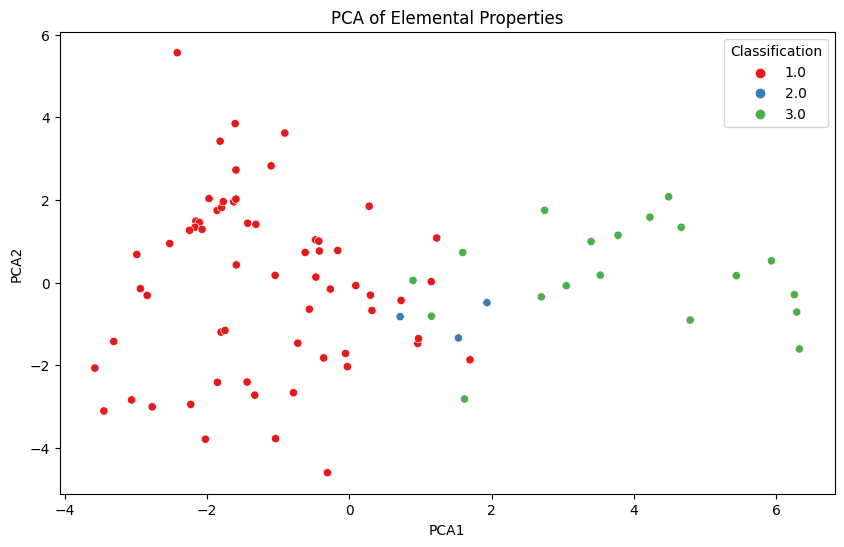

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df2.drop(columns=[classification_column]))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Classification'] = df2[classification_column]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Classification', palette='Set1', data=pca_df)
plt.title('PCA of Elemental Properties')
plt.show()


#### Key Observations from the PCA Plot:
Separation by Classification:
- The metals (red) are mostly grouped together on the left side of the figure, namely in the negative range of the first major component (PCA1). This implies that the characteristics that strongly indicate the presence of metals are prevalent in this component.
- Metalloids (Blue): Metalloids are seen to be somewhat distributed between metals and nonmetals, with a predominant concentration in the middle of PCA1. The location of metalloids indicates that they possess characteristics of both metals and nonmetals, as seen by their intermediate PCA1 scores.
- Nonmetals (Green): Concentrated on the right side, namely towards the positive end of PCA1, suggesting a significant presence of nonmetal characteristics in this primary component.

Spread Along PCA2:
- The dispersion along the second principle component (PCA2) is not as clear for classification purposes, but it does reveal some internal variability within each group. This dispersion may indicate differences in characteristics such as electron affinity, specific heat, or other less prominent attributes that are not as well distinguished by PCA1.

#### Interpretation of PCA Dimensions:
- PCA1 likely reflects a composite of discerning characteristics such as atomic weight, electronegativity, and ionization energy, which successfully differentiate metals from nonmetals. The juxtaposition of metals and nonmetals at opposing ends of the spectrum, with metalloids occupying an intermediate position, substantiates this view.
- PCA2: It may capture differences in attributes that are not as influential for classification but nonetheless meaningful within each group, such as melting points or thermal conductivity. The observed heterogeneity along PCA2 within each group indicates variations in secondary features.

#### Conclusion and Insights:
- The PCA analysis allows for a distinct visual distinction between metals, metalloids, and nonmetals based on their elemental characteristics. It efficiently decreases the number of dimensions in intricate data, highlighting the fundamental patterns that differentiate these groupings.
- The plot reinforces the idea that principle component one captures the most amount of variation and helps distinguish the main groups, while additional factors affecting PCA2 enhance our comprehension of distinctions within each category.
- This Principal Component Analysis (PCA) may be vital in subsequent studies where differentiations between these groupings are pivotal, such as in the field of materials science research, educational applications, or during the process of formulating novel chemical compounds where comprehending element behavior is essential.

Overall, this PCA plot not only validates established classifications but also graphically highlights the connections and distinctions within and between the groupings of components, providing a helpful tool for further scientific investigation and hypothesis formulation.

# 7. Feature Importance

**Random Forest Feature Importance:** Random Forest calculates the importance of a feature by looking at how much the tree nodes, which use that feature, reduce the impurity (Gini impurity or entropy). If I(feature) is the importance of a feature, it can be calculated as:
$$
  I_{\text{feature}} = \sum_{t \in \text{Trees}} \frac{N_t}{N} \cdot \Delta i_t
$$



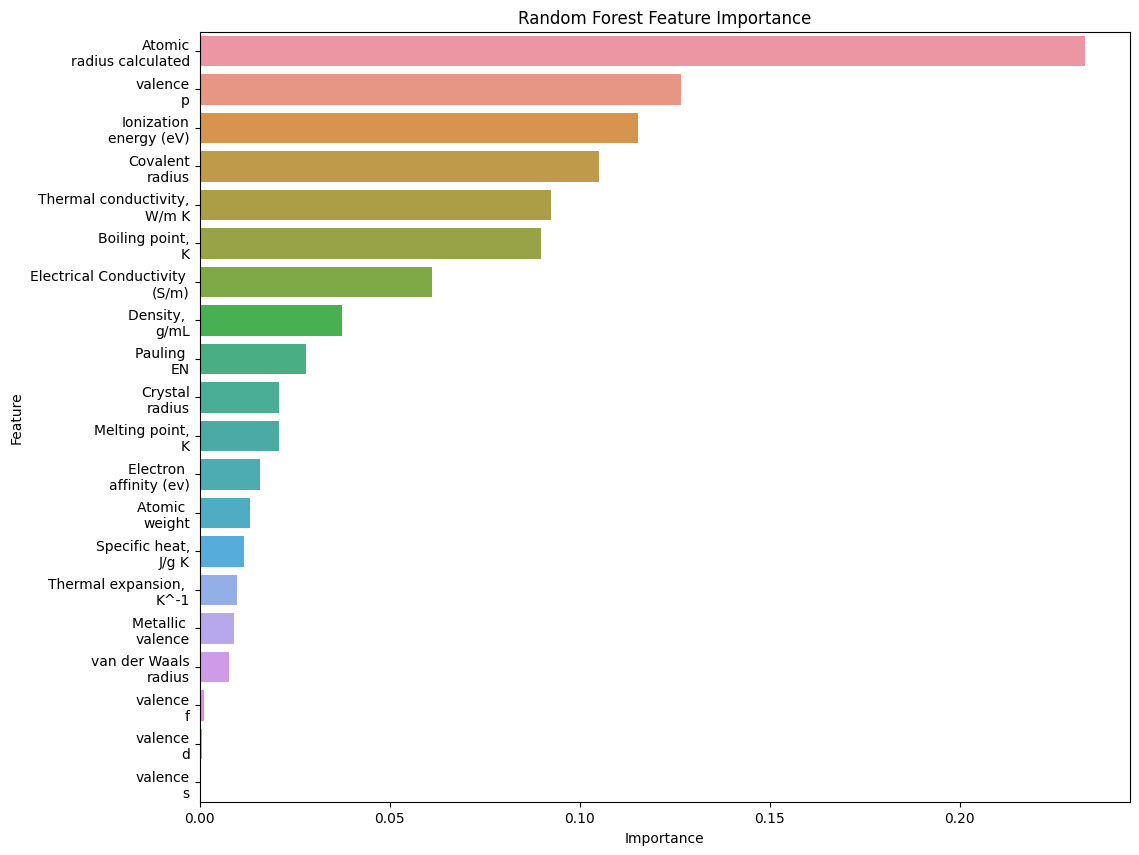

In [ ]:
rf = RandomForestClassifier()
rf.fit(df2.drop(columns=[classification_column]), df2[classification_column])

rf_importances = rf.feature_importances_

rf_feature_importances = pd.DataFrame({
    'Feature': df2.drop(columns=[classification_column]).columns,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importances)
plt.title('Random Forest Feature Importance')
plt.show()


#### Atomic Radius Calculated
Importance: Highest (around 0.2)
Interpretation: This suggests that atomic radius is the most significant feature in determining an element's classification. Larger atomic radii typically correlate with metallic characteristics due to less tightly held electrons.

#### Ionization Energy
Importance: Second highest (around 0.175)
Interpretation: Ionization energy is critical in predicting whether an element is a metal, metalloid, or nonmetal. Lower ionization energies generally indicate metallic properties as it's easier for metals to lose electrons.

#### Valence Electrons in p Orbital (Valence p)
Importance: Significantly high (around 0.125)
Interpretation: The number of valence electrons in the p orbital is highly indicative of chemical properties and reactivity, crucial for differentiating nonmetals, which typically have more p electrons.

#### Boiling Point
Importance: Moderate (around 0.1)
Interpretation: The boiling point can reflect the strength of bonds within an element, with higher boiling points often associated with metals due to strong metallic bonding.

#### Thermal Conductivity
Importance: Moderately high (around 0.075)
Interpretation: Metals typically have high thermal conductivity, making this a useful feature for classification, especially distinguishing metals from nonmetals and metalloids.

#### Covalent Radius
Importance: Moderate (around 0.075)
Interpretation: Reflects the size of atoms when they form covalent bonds, which is crucial in understanding how elements bond and interact chemically.

#### Density
Importance: Moderate (around 0.075)
Interpretation: Higher densities are generally characteristic of metals, influenced by their atomic mass and structure.

#### Less Influential Features
Specific Heat, Thermal Expansion, Van der Waals Radius, Valence d, f, s: These features have relatively low importance scores (below 0.05). This indicates that while they contribute to the model, they are not primary drivers in distinguishing between the element categories within this dataset.

>Overall Implications:
>The feature significance output from the Random Forest model provides a visual representation of the elemental features that have the highest predictive power for determining the categorization of an element. The properties that have the most impact are those that are associated with atomic structure and the energy needed for electron interactions, such as atomic radius, ionization energy, and boiling point. On the other hand, particular heat, thermal expansion, and less significant valence electron configurations have less impact.

>This knowledge is very helpful for improving models, directing research, and aiding teaching. It helps to emphasize the most important characteristics for understanding how elements behave in different scientific and practical situations.

# 8. Strategy
#### Data Preparation and Preprocessing
- **Feature Selection**: Based on the feature importance and PCA analysis, prioritize features like atomic radius, ionization energy, electronegativity, density, and thermal properties. These have shown significant variance and importance in distinguishing between the classes.
- **Normalization/Standardization**: Given the varying scales of the elemental properties (e.g., boiling point in Kelvin, density in g/mL), standardizing or normalizing the data is crucial. Standardization (subtracting the mean and dividing by the standard deviation) is typically more robust to outliers.
    - **Normalization (Min-Max Scaling)**: Transform the data to a range [0, 1]:
  $$
  X' = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
  $$
    - **Standardization (Z-score Normalization)**: Transform the data to have a mean of 0 and a standard deviation of 1:
  $$
  X' = \frac{X - \mu_X}{\sigma_X}
  $$

#### Dimensionality Reduction
- **Principal Component Analysis (PCA)**: Implement PCA to reduce the dimensionality of the data while retaining most of the variance. PCA will transform the features into a new coordinate system, reducing the number of features and potentially improving model performance by removing noise.
  - Compute the covariance matrix of the data:
    $$
    \Sigma = \frac{1}{n-1} (X - \mu_X)^T (X - \mu_X)
    $$
  - Compute the eigenvalues and eigenvectors of the covariance matrix.
  - Transform the data into the space defined by the top 𝑘 eigenvectors:
    $$
    X' = X \cdot W_k
    $$

#### Model Selection
**Random Forest**: Given its performance in feature importance analysis and its robustness in handling non-linear relationships and interactions between features, a Random Forest classifier would be a suitable choice.

#### Model Training and Validation
**Cross-Validation**: Split data into 𝑘 folds and train the model 𝑘 times, each time using a different fold as the validation set and the rest as the training set.
$$
\text{CV score} = \frac{1}{k} \sum_{i=1}^{k} \text{Accuracy}_i
$$

#### Model Evaluation
- Confusion Matrix: Evaluate the model's performance using a confusion matrix, which will help identify not just the overall accuracy but also how well the model performs for each class.
- Performance Metrics: Calculate accuracy, precision, recall, and F1-score to gain insights into the model's accuracy, especially its ability to minimize false positives and false negatives. True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN) are used to calculate:
  - Accuracy:
  $$
  Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
  $$
  - Precision:
  $$
  Precision = \frac{TP}{TP + FP}
  $$
  - Recall:
  $$
  Recall = \frac{TP}{TP + FN}
  $$
  - F1-Score:
  $$
  F1\text{-}Score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
  $$

#### Interpretation and Improvement
- Feature Importance Re-evaluation: After model training, evaluate the feature importance again to see if the importance of features has shifted.
- Model Updating: Based on the performance metrics and feature importance, iteratively adjust the model. This might include adding or removing features, or tweaking the model's hyperparameters.


# 9. Conclusion
This research has formulated a fundamental approach for constructing a machine learning model that categorizes elements as metals, nonmetals, or metalloids according to their elemental characteristics. By doing thorough data pretreatment and exploratory data analysis, we were able to identify the crucial factors that have the ability to impact the categorization of an element. Electronegativity, electron affinity, ionization energy, and thermal characteristics showed strong connections with elemental categories, emphasizing their significance in selecting features.

A Random Forest classifier is suggested because to its capacity to handle non-linear interactions and its resilience against overfitting. The technique entails a detailed strategy for training a complete model and proposes the use of cross-validation to guarantee correctness and dependability in subsequent stages of model development.


The research highlights the need of using a systematic strategy throughout the early stages of constructing a predictive model. The document provides a clear plan for the future execution, which includes possible measures for evaluating the model's performance, including as accuracy, precision, recall, and F1-score. These metrics are crucial for determining the model's capacity to effectively categorize components.

In summary, this first study sets the foundation for a systematic approach to developing models, which has the potential to greatly improve our knowledge of elemental characteristics and how they affect categorization. Subsequent efforts will concentrate on executing the suggested approaches, carrying out meticulous testing, and verifying the model to guarantee its efficacy and suitability in scientific and educational fields.